In [2]:
% matplotlib inline
% run ./ipy_setup.py

In [70]:
import pysam
bam_fp = pysam.AlignmentFile('/hpc/users/neffr01/jason_new/falcon_test/preads4falcon_aligned.sort.bam', 'rb')
edges_list = pd.read_csv('/hpc/users/neffr01/jason_new/falcon_test/2-asm-falcon/sg_edges_list', sep=' ', header=None)

In [ ]:
edge_set = set()
for i in list(edges_list[edges_list[7] == 'G'][0]):
    edge_set.add(i[0:-2])


In [ ]:
bam_fp = pysam.AlignmentFile('/hpc/users/neffr01/jason_new/falcon_test/preads4falcon_aligned.sort.bam', 'rb')
out_bam = pysam.AlignmentFile('/hpc/users/neffr01/jason_new/falcon_test/edges_reads.bam', 'wb', template=bam_fp)
for bamread in bam_fp:
    name = bamread.query_name.split('/')[0]
    if name in edge_set:
        print name, bamread.reference_id, bamread.pos, bamread.aend
        out_bam.write(bamread)
out_bam.close()

In [16]:
import networkx as nx
net = nx.read_dot('/hpc/users/neffr01/jason_new/falcon_test/2-asm-falcon/sg_edges_list.dot')

In [9]:
import networkx as nx
jasonnet = nx.read_gexf('/hpc/users/neffr01/jason_new/falcon_unzip_jason_071715/3-falcon_unzip/000000F/000000F_0.gexf')

In [ ]:
nx.draw_graphviz(jasonnet, prog='neato')

In [ ]:
jasonnet.degree()

In [33]:
translate_dict = dict()
translate_file = pd.read_csv('/hpc/users/neffr01/jason_new/falcon_unzip_jason_071715/1-preads_ovl/realigned_preads_locations.tsv', 
                             sep="\t", header=None)
translate_file[0] = translate_file[0].map(lambda x: x[0:9])
for a,i in translate_file.iterrows():
    if i[1] != 256:
        translate_dict[i[0]] = (i[2], i[3], int(i[3])+int(i[5]))

In [12]:
edges_list = set()
for i in jasonnet.nodes():
    if (jasonnet.out_degree(i) > 1) | (jasonnet.in_degree(i) > 1):
        contributedegree = 0
        for pred in jasonnet.predecessors(i):
            if jasonnet[pred][i]['src'] == 'P':
                contributedegree += 1
        for succ in jasonnet.successors(i):
            if jasonnet[i][succ]['src'] == 'P':
                contributedegree += 1
        if contributedegree == 3:
            print i[0:-2]
            edges_list.add(i[0:-2])
edges_list_2 = set()
for i in edges_list:
    try:
        edges_list_2.add(translate_dict[i])
    except:
        print "ERROR at ", i

000115125
000012237
000015865
000078959
000134868
000008561
000096590
000021028
000125192
000109842
000094653
000131148
000090099
000136365
000063012
000121246
000032830
000075952
000076423
000060014
000057333
000025548
000094837
000114367
000128952
000089197
000121880
000018829
000068789
000093581
000076867
000018319
000106916
000088429
000127640
000065129
000119933
000047478
000089948
000073021
000026756
000100199
000015460
000034079
000037600
000091552
000038865
000042984
000043709
000070203
000055856
000128701
000035921
000090380
000062972
000119944
000049187
000004611
000129867
000091849
000022572
000094748
000112085
000006156
000046182
000100861
000127501
000067061
000062783
000032452
000038194
000041352
000052296
000114729
000112550
000001516
000032763
000108200
000063490
000090490
000088772
000037794
000130012
000087310
000060143
000058438
000114689
000015215
000135617
000084114
000106586
000125397
000014674
000013174
000107724
000133158
000010239
000039631
000084119
000106411


In [30]:
translate_file.tail()

,0,1
0,,
133293,133293,m150202_063008_42163R_c10077989255000000182316...
133294,133294,m140612_144413_42156_c100652082550000001823118...
133295,133295,m150202_063008_42163R_c10077989255000000182316...
133296,133296,m150131_204023_42163R_c10078029255000000182316...
133297,133297,m150129_031217_42177R_c10077985255000000182316...


In [34]:
haps_to_reads = dict()
for node in jasonnet.nodes():
    name = node[0:-2]
    hap = jasonnet.node[node]['phase'].split("_")[0]
    #print node[0:-2], jasonnet.node[node]['phase'].split("_")[0]
    try:
        if translate_dict[name][0] != '000000F':
            continue
        if hap in haps_to_reads:
            haps_to_reads[hap].append(translate_dict[name])
        else:
            haps_to_reads[hap] = [translate_dict[name]]
    except:
        print >>sys.stderr, "ERROR: read not translatable", str(name)

In [42]:
out_json = dict()
sorted_keys = sorted([int(i) for i in haps_to_reads.keys()])
del sorted_keys[0]
for key in sorted_keys:
    group = haps_to_reads[str(key)]
    intervals = [(i[1],i[2]) for i in group]
    merged = mergeOverlappingInts(intervals)
    min_merged = merged[0][0]
    max_merged = merged[-1][1]
    out_json[key] = {'min': min_merged,
                     "max": max_merged, 
                     "ranges": merged}
    print key, min_merged, max_merged, merged
with open("/hpc/users/neffr01/jason_new/falcon_unzip_jason_071715/haplotypes_to_ranges_000000F.json", 'w') as fp:
    json.dump(out_json, fp, 'ascii')

1 33164599 33280560 [(33164599, 33189034), (33218331, 33254375), (33263570, 33280560)]
2 33004770 33134061 [(33004770, 33067272), (33080573, 33091482), (33121509, 33134061)]
3 32949083 32970698 [(32949083, 32970698)]
4 32868614 32952641 [(32868614, 32910159), (32912300, 32925410), (32938884, 32952641)]
5 32697542 32843758 [(32697542, 32746303), (32748302, 32769461), (32780561, 32796421), (32799494, 32843758)]
6 32603135 32702483 [(32603135, 32619475), (32627703, 32702483)]
7 32510036 32582756 [(32510036, 32551988), (32553186, 32582756)]
8 32422907 32448696 [(32422907, 32448696)]
9 32385919 32415371 [(32385919, 32415371)]
10 32060583 32177698 [(32060583, 32091887), (32107692, 32139353), (32154849, 32177698)]
11 31930743 32064121 [(31930743, 31985851), (31993219, 32004466), (32028330, 32045694), (32046708, 32046809), (32056610, 32064121)]
12 31842229 31931932 [(31842229, 31893315), (31899250, 31931932)]
13 31814692 31847856 [(31814692, 31824697), (31828310, 31847856)]
14 31659463 3173560

In [24]:
def mergeOverlappingInts(intervals):
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return merged

In [14]:
linked_blocks = []
for i in jasonnet.nodes():
    curr_phase = jasonnet.node[i]['phase'].split('_')[0]
    curr_hap = jasonnet.node[i]['phase'].split('_')[1]
    if curr_phase == '-1':
        continue
    for n in jasonnet.predecessors(i):
        next_phase = jasonnet.node[n]['phase'].split('_')[0]
        next_hap = jasonnet.node[n]['phase'].split('_')[1]
        if next_phase == '-1':
            continue
        if next_phase != curr_phase:
            linked_blocks.append([(int(curr_phase), int(curr_hap)), (int(next_phase), int(next_hap))])
    for n in jasonnet.successors(i):
        next_phase = jasonnet.node[n]['phase'].split('_')[0]
        next_hap = jasonnet.node[n]['phase'].split('_')[1]
        if next_phase == '-1':
            continue
        if next_phase != curr_phase:
            linked_blocks.append([(int(curr_phase), int(curr_hap)), (int(next_phase), int(next_hap))])

hap_link_graph = nx.Graph()
for i in linked_blocks:
    cisweight, transweight = 0,0
    (u, hap1), (v,hap2) = i
    weight = 0
    if hap1 == hap2:
        cisweight = 1
    else:
        transweight = 1
    if hap_link_graph.has_edge(u,v):
        currcis = hap_link_graph.edge[u][v]['cis']
        currtrans = hap_link_graph.edge[u][v]['trans']
        hap_link_graph.add_edge(u,v,cis=currcis+cisweight, trans=currtrans+transweight)
    else:
        hap_link_graph.add_edge(u,v,cis = cisweight, trans = transweight)

for e,i in hap_link_graph.edges():
    if hap_link_graph.edge[e][i]['cis'] == hap_link_graph.edge[e][i]['trans']:
        hap_link_graph.remove_edge(e,i)
for i in hap_link_graph.nodes():
    if hap_link_graph.degree(i) == 0:
        hap_link_graph.remove_node(i)

In [128]:
nx.write_gexf(hap_link_graph, '/hpc/users/neffr01/2work/falcon_unzip_jason_071715/hap_link_graph.gexf')

In [15]:
for i in list(nx.connected_component_subgraphs(hap_link_graph)):
    print i.nodes()

[1, 2]
[3, 4]
[11, 12]
[14, 15]
[17, 18, 19]
[26, 27]
[32, 30, 31]
[34, 35]
[46, 47]
[48, 49]
[51, 52]
[62, 63]
[68, 69]
[80, 79]
[83, 84, 175]
[97, 98]
[104, 105]
[109, 110]
[115, 116, 117]
[120, 121, 122]
[128, 127]
[129, 130, 131, 132]
[133, 134]
[136, 137]
[140, 141]
[148, 149]
[152, 153]
[156, 157, 158]
[162, 163]
[164, 165]
[168, 167]
[185, 186]
[188, 189]
[197, 198]
[203, 204]
[206, 207]
[209, 210]
[216, 214, 215]
[220, 221]
[229, 230]
[232, 233, 234]
[238, 239]
[241, 242]
[252, 253]
[259, 260, 261]
[272, 273]


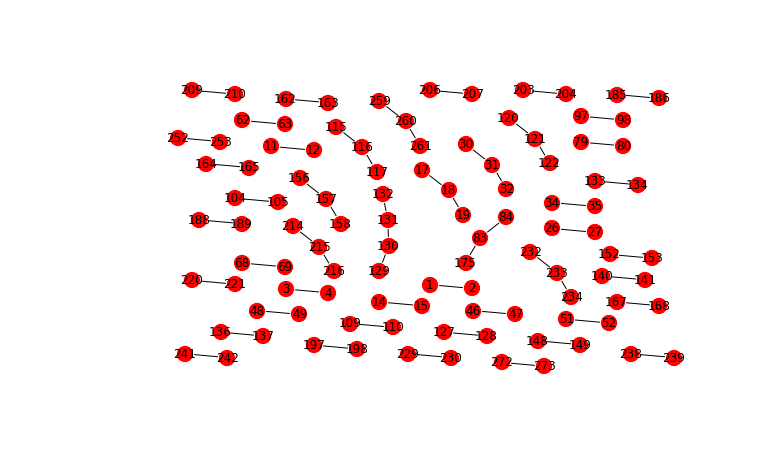

In [7]:
nx.draw_graphviz(hap_link_graph, with_labels=True)

In [13]:
edges_list_2 = set()
net = jasonnet
in_out_nodes = [i for i in net.nodes() if net.degree(i) == 1]
#print in_out_nodes
sys.stdout.flush()

node_order = []
curr_degree = 2
start_node = in_out_nodes[0]
next_node = net.edges(start_node)[0][1]
curr_degree = net.degree(next_node)
#print start_node
count = 0
last_node = start_node
curr_node = next_node
#print curr_node
while count < 10000:
    count += 1
    #print net.edges(curr_node)
    next_node = [b for a,b in net.edges(curr_node) if b != last_node]
    if len(next_node) == 0:
        print "BREAK at", curr_node
        break
    next_node = next_node[0]
    print last_node, curr_node, next_node
    last_node = curr_node
    curr_node = next_node
    curr_degree = net.degree(curr_node)

000040061:B 000117543:B 000012076:B
000117543:B 000012076:B 000090971:B
000012076:B 000090971:B 000096081:B
000090971:B 000096081:B 000043382:B
000096081:B 000043382:B 000042203:B
000043382:B 000042203:B 000114894:B
000042203:B 000114894:B 000060829:B
000114894:B 000060829:B 000050774:B
000060829:B 000050774:B 000095034:B
000050774:B 000095034:B 000035335:B
000095034:B 000035335:B 000064072:B
000035335:B 000064072:B 000125300:B
000064072:B 000125300:B 000076303:B
000125300:B 000076303:B 000027746:B
000076303:B 000027746:B 000055741:B
000027746:B 000055741:B 000103483:B
000055741:B 000103483:B 000064071:B
000103483:B 000064071:B 000130830:B
000064071:B 000130830:B 000089831:B
000130830:B 000089831:B 000023627:B
000089831:B 000023627:B 000106324:B
000023627:B 000106324:B 000075254:B
000106324:B 000075254:B 000126599:B
000075254:B 000126599:B 000027936:B
000126599:B 000027936:B 000107920:B
000027936:B 000107920:B 000132925:B
000107920:B 000132925:B 000030624:B
000132925:B 000030624:B 0000

In [ ]:
%pylab inline

G = jasonnet

position=nx.graphviz_layout(G, prog='dot', args="-Grankdir=LR" ) 

figure(figsize=(45,8))

ax=subplot(1,1,1)

minx = 1000000
maxx = 0

miny = 1000000
maxy = 0

count = 0
colmap = dict(zip((0,1,2,3,4,5),("r","b","y","c","m","g")))
for e in G.edges():
    v, w = e

    if G[v][w]["src"] != "P":
        continue
        
    phase0 = G.node[v]["phase"].split("_")
    phase1 = G.node[w]["phase"].split("_")
    if int(phase0[0]) not in range(60,69) and int(phase1[0]) not in range(60,69):
        continue
    if int(phase0[0]) == -1:
        col = "k"
    else:
        col =  colmap[int(phase0[0]) % 6]     
    
    xx, yy = zip(position[e[0]], position[e[1]]) 
    
    if xx[0] < 500000 or xx[0] > 500000 + 50000:
        continue
    
    ax.plot( xx, yy, ".-"+col, markersize=1, lw=2) 
    
    minx = min(minx, min(xx))
    maxx = max(maxx, max(xx))
    miny = min(miny, min(yy))
    maxy = max(maxy, max(yy))
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ylim( miny-100, maxy + 100)
xlim( minx-1000, maxx + 1000)

In [ ]:
!hostname

In [ ]:
#%matplotlib inline
G = jasonnet
fig = plt.figure(figsize=(45,8))

ax=plt.subplot(1,1,1)

minx = 1000000
maxx = 0

miny = 1000000
maxy = 0

count = 0
colmap = dict(zip((0,1,2,3,4,5),("r","b","y","c","m","g")))
for e in G.edges():
    v, w = e

    phase0 = G.node[v]["phase"].split("_")
    phase1 = G.node[w]["phase"].split("_")
    if int(phase0[0]) not in range(67,69) and int(phase1[0]) not in range(67,69):
        continue
    if G[v][w]["h_edge"] != "Y":
        continue

    if int(phase0[0]) == -1:
        col = "k"
    else:
        col =  colmap[int(phase0[0]) % 6]     
    
    xx, yy = zip(position[e[0]], position[e[1]]) 

        
    ax.plot(xx, yy, ".-"+col, markersize=1, lw=2) 
    
    minx = min(minx, min(xx))
    maxx = max(maxx, max(xx))
    miny = min(miny, min(yy))
    maxy = max(maxy, max(yy))
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ylim( miny-100, maxy + 100)
xlim( minx-1000, maxx + 1000)

In [ ]:
%matplotlib inline

In [ ]:
nx.draw_graphviz(jasonnet)

In [ ]:
import networkx as nx
net = nx.read_dot('/hpc/users/neffr01/jason_new/falcon_test/2-asm-falcon/sg_edges_list.dot')

In [12]:
edges_list_2 = set()
in_out_nodes = [i for i in net.nodes() if net.degree(i) == 1]
#print in_out_nodes
sys.stdout.flush()

node_order = []
curr_degree = 2
start_node = in_out_nodes[0]
next_node = net.edges(start_node)[0][1]
curr_degree = net.degree(next_node)
#print start_node
count = 0
last_node = start_node
curr_node = next_node
#print curr_node
while count < 10:
    count += 1
    #print net.edges(curr_node)
    next_node = [b for a,b in net.edges(curr_node) if b != last_node][0]
    print last_node, curr_node, next_node
    last_node = curr_node
    curr_node = next_node
    curr_degree = net.degree(curr_node)

NameError: name 'net' is not defined

In [ ]:
nx.draw_graphviz(net, prog='dot')

In [19]:
edges_list_2 = set()
for i in jasonnet.nodes():
    if net.degree(i) > 2:
        print net.node[i[0:-2]]['label']
        edges_list_2.add(net.node[i]['label'].encode('ascii'))

KeyError: '000069877'

In [10]:
import pysam
bam_fp = pysam.AlignmentFile('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hg002_000000F.new.merged.bam.rg.bam', 'rb')
#out_bam = pysam.AlignmentFile('/hpc/users/neffr01/jason_new/falcon_unzip_jason_071715/edges_reads.bam', 'wb', template=bam_fp)
split_list = []
for bamread in bam_fp:
    name = bamread.query_name
    if name in edges_list_2:
        print name, bamread.reference_id, bamread.pos, bamread.aend
        if bamread.reference_id == 0:
            split_list.append((bamread.pos, bamread.aend))
        #out_bam.write(bamread)
#out_bam.close()

KeyboardInterrupt: 

In [8]:
excelfile = '/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv13_mq10/hg002.000000F.interblock_stats.before.tsv'
interblock_stats = pd.read_csv(excelfile, sep='\t')


NameError: name 'split_list' is not defined

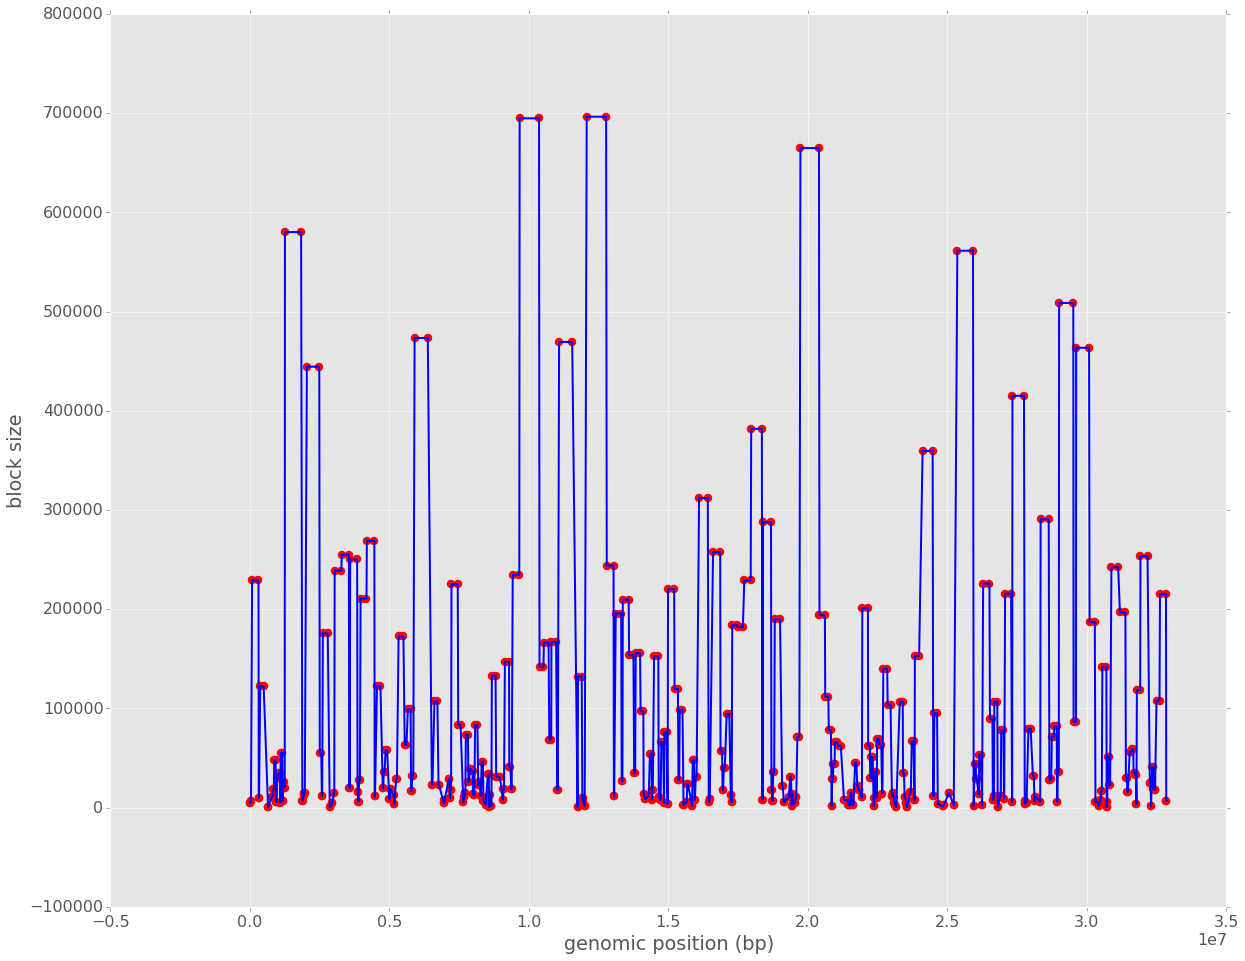

In [9]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20, 16)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'
a = interblock_stats.block1_end - interblock_stats.block1_size
x = interblock_stats.block1_end
y = interblock_stats.block1_size
long_x = [j for i in zip(a,x) for j in i]
long_y = [j for i in y for j in (i,i)]
fig, ax = plt.subplots()
ax.set_ylabel("block size")
ax.set_xlabel("genomic position (bp)")
ax.plot(long_x, long_y, color='b')
ax.scatter(long_x, long_y, color='r', linewidths=4)
for s,e in split_list: # this is a list of positions from the bubble
    ax.axvspan(s,e,ymin=0, ymax=2500000, alpha=1)
ax.minorticks_on()
ax.set_title("Structural variant intersection with haplotype block defintions")
ax.set_xlim([0, 33300000])
ax.set_ylim([-200000,2500000])
#print "N50: ", n50(y)
print "blocks: ", len(y)
plt.show()